In [1]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import time
import math
import netCDF4 as nc

#from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler,Normalizer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, r2_score
from sklearn.feature_selection import mutual_info_regression

import matplotlib.dates as mdates
import matplotlib.colors
import matplotlib.ticker as ticker

from pysolar.solar import *
import pytz
import shap
import pickle
import multiprocessing

#  32.5,  33.5
# -97.5, -96.5

In [2]:
folder = "spatial"
node_id = "10004098"
dir_out = "../figures/" + folder + "/"
dir_data = "../data/"

fn_in = dir_data + "driving_" + node_id + "_landsat_NEXRAD.csv"


In [3]:
df = pd.read_csv(fn_in, index_col = 'UTC')

In [4]:
features = ['Zenith',
            'SR1', 'SR2', 'SR3', 'SR4',
            'reflectivity 0km', 'reflectivity 1km',
            'reflectivity 2km', 'reflectivity 3km', 'reflectivity 4km',
            'reflectivity 5km', 'reflectivity 6km', 'reflectivity 7km',
            'reflectivity 8km', 'reflectivity 9km', 'reflectivity 10km',
            'velocity 0km', 'velocity 1km', 'velocity 2km', 'velocity 3km',
            'velocity 4km', 'velocity 5km', 'velocity 6km', 'velocity 7km',
            'velocity 8km', 'velocity 9km', 'velocity 10km', 'spectrum_width 0km',
            'spectrum_width 1km', 'spectrum_width 2km', 'spectrum_width 3km',
            'spectrum_width 4km', 'spectrum_width 5km', 'spectrum_width 6km',
            'spectrum_width 7km', 'spectrum_width 8km', 'spectrum_width 9km',
            'spectrum_width 10km', 'differential_phase 0km',
            'differential_phase 1km', 'differential_phase 2km',
            'differential_phase 3km', 'differential_phase 4km',
            'differential_phase 5km', 'differential_phase 6km',
            'differential_phase 7km', 'differential_phase 8km',
            'differential_phase 9km', 'differential_phase 10km',
            'differential_reflectivity 0km', 'differential_reflectivity 1km',
            'differential_reflectivity 2km', 'differential_reflectivity 3km',
            'differential_reflectivity 4km', 'differential_reflectivity 5km',
            'differential_reflectivity 6km', 'differential_reflectivity 7km',
            'differential_reflectivity 8km', 'differential_reflectivity 9km',
            'differential_reflectivity 10km', 'cross_correlation_ratio 0km',
            'cross_correlation_ratio 1km', 'cross_correlation_ratio 2km',
            'cross_correlation_ratio 3km', 'cross_correlation_ratio 4km',
            'cross_correlation_ratio 5km', 'cross_correlation_ratio 6km',
            'cross_correlation_ratio 7km', 'cross_correlation_ratio 8km',
            'cross_correlation_ratio 9km', 'cross_correlation_ratio 10km',
            'ROI 0km', 'ROI 1km', 'ROI 2km', 'ROI 3km', 'ROI 4km', 'ROI 5km',
            'ROI 6km', 'ROI 7km', 'ROI 8km', 'ROI 9km', 'ROI 10km']

target = 'Illuminance'

In [5]:
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

In [6]:
RANDOM_STATE = 42
n_jobs = multiprocessing.cpu_count()

In [7]:
# start_time = time.time()

# # XGB Model, grid search to find best parameter
# regr = XGBRegressor(random_state = RANDOM_STATE,
#                      n_jobs = n_jobs
#                     )

# param_grid = {  'max_depth': list(range(1,20+1)),
#                 'n_estimators': list(range(20,50+1)),
#                 'subsample': np.array(list(range(1,2+1)))/10,
#                 'colsample_bytree': np.array(list(range(1,10+1)))/10,
#                 'learning_rate': [0.3] # default 0.3
# }
# CV_regr = RandomizedSearchCV(estimator = regr, param_distributions = param_grid,
#                              n_iter = 500, cv =2, verbose = 3)

# CV_regr.fit(X_train, y_train)
# print(CV_regr.best_params_)
# print(CV_regr.best_score_)

# print("--- %s seconds ---" % (time.time() - start_time))

In [8]:
n_estimators = 31
max_depth = 11
subsample = 1.0
colsample_bytree = 1.0
learning_rate = 0.3 # default 0.3

start_time = time.time()

regr = XGBRegressor(random_state = RANDOM_STATE,
                    n_estimators = n_estimators, # default 100
                    max_depth = max_depth, # default 6
                    subsample = subsample,
                    colsample_bytree = colsample_bytree,
                    learning_rate = learning_rate,
                    n_jobs = n_jobs
                    )
regr.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 6.634165048599243 seconds ---


In [9]:
# save model
structure = '_dep_' + str(max_depth)\
            + '_ne_' + str(n_estimators)\
            + '_sr_' + str(subsample)\
            + '_fr_' + str(colsample_bytree)\
            + '_lr_' + str(learning_rate)
fn_model = '../models/spatial_XGB_'+ target + structure + '.sav'
pickle.dump(regr, open(fn_model, 'wb'))


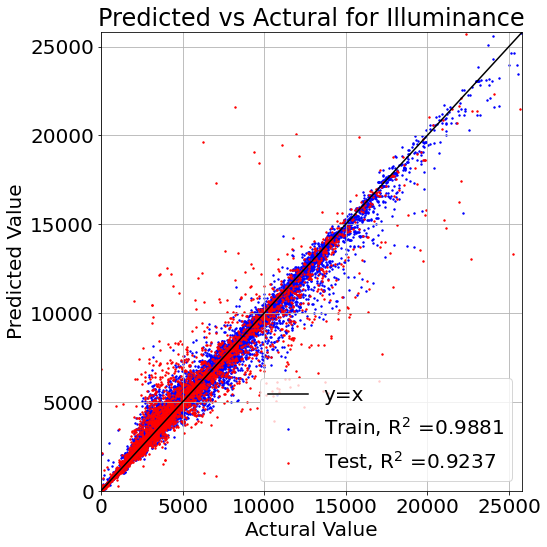

In [42]:
from sklearn.metrics import r2_score

y_train_pred = regr.predict(X_train) # for test score
y_test_pred = regr.predict(X_test) # for test score

train_score =  r2_score(y_train, y_train_pred)
test_score = r2_score(y_test, y_test_pred)

y_min = 0 # np.amin(y_train.values)
y_max = np.amax(y_train.values)
y_mean = np.mean(y_train.values)
y_std = np.std(y_train.values)
y_line = np.linspace(y_min,y_max,100)

plt.rcParams["figure.figsize"] = (8, 8) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
plt.plot(y_line,y_line, '-k', label='y=x')
plt.scatter(y_train,y_train_pred, s=2, c = 'blue',label = 'Train, R$^{2}$ ='+str(train_score)[:6])
plt.scatter(y_test,y_test_pred, s=2, c = 'red', label = 'Test, R$^{2}$ ='+str(test_score)[:6])
plt.xlim((y_min, y_mean + 5*y_std))
plt.ylim((y_min, y_mean + 5*y_std))
ax.set_title('Predicted vs Actural for ' + target)
ax.set_xlabel('Actural Value')
ax.set_ylabel('Predicted Value')
plt.legend( loc='lower right')
plt.grid()
plt.tight_layout()

if not os.path.exists(dir_out + target):
    os.mkdir(dir_out + target)
plt.savefig(dir_out + target +'/spatial_XGB_performance_'+target+structure+'.png')


In [40]:
# Create object that can calculate shap values
num_shap = 1000
X_sample = shap.sample(X_train, num_shap)
explainer = shap.TreeExplainer(regr)
# Calculate shap_values
shap_values = explainer.shap_values(X_sample)

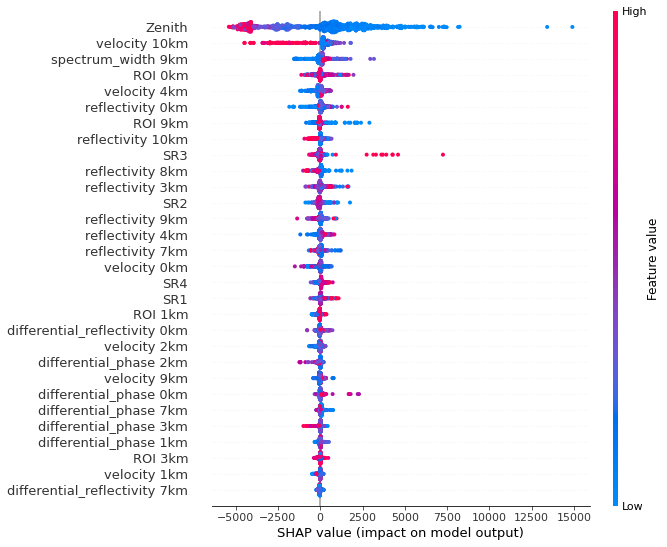

In [44]:
# plot
shap.summary_plot(shap_values, X_sample,
                  plot_size=(10,8),#'auto'
                  max_display = 30,
                  show=False
                 )
plt.tight_layout()
plt.savefig(dir_out + target + '/spatial_XGB_shap_'+ target +'.png')